In [8]:
## Config
from dataclasses import dataclass

@dataclass
class RNAConfig:
    """Global configuration for the RNAcompete Data Pipeline."""
    
    # Data Path
    DATA_PATH: str = "norm_data.txt" #NOTE: Only change this if you want to use a different path
    
    # Metadata is an Excel file
    METADATA_PATH: str = "metadata.xlsx" #NOTE: Only change this if you want to use a different path
    METADATA_SHEET: str = "Master List--Plasmid Info"
    
    # Save Path
    SAVE_DIR: str = "data" #NOTE: Only change this if you want to use a different path
    
    # Sequence Parameters
    SEQ_MAX_LEN: int = 41
    ALPHABET: str = "ACGUN"
    
    # Preprocessing
    CLIP_PERCENTILE: float = 99.95
    EPSILON: float = 1e-6  # For numerical stability
    
    # Split Identifiers
    TRAIN_SPLIT_ID: str = "SetA"
    TEST_SPLIT_ID: str = "SetB"
    
    VAL_SPLIT_PCT: float = 0.2
    SEED: int = 42 # NOTE: Change this only if you want to test reproducibility

In [2]:
## Utils
import os
import random
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from typing import List, Tuple


def configure_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


class RNACompeteLoader:
    def __init__(self, config: RNAConfig):
        """
        Initializes the loader.
        """
        self.cfg = config
        self.meta_df = None
        self.data_df = None
        self.protein_to_id = None

        # Setup Encoding
        self.char_map = {
            'A': np.array([1, 0, 0, 0], dtype=np.float32),
            'C': np.array([0, 1, 0, 0], dtype=np.float32),
            'G': np.array([0, 0, 1, 0], dtype=np.float32),
            'U': np.array([0, 0, 0, 1], dtype=np.float32),
            'N': np.array([0.25, 0.25, 0.25, 0.25], dtype=np.float32)
        }
        self.padding_vec = np.zeros(4, dtype=np.float32)

    def _ensure_data_loaded(self):
        """Helper to load the heavy files only when necessary."""
        if self.data_df is not None:
            return
        
        # Load Metadata
        print(f"Loading Metadata from {self.cfg.METADATA_PATH}...")
        start_time = time.time()
        try:
            if self.cfg.METADATA_PATH.endswith('.xlsx'):
                # Requires 'openpyxl' installed!
                self.meta_df = pd.read_excel(
                    self.cfg.METADATA_PATH, 
                    sheet_name=self.cfg.METADATA_SHEET
                )
            else:
                self.meta_df = pd.read_csv(self.cfg.METADATA_PATH)
        except Exception as e:
            print(f"Error loading metadata: {e}")
            raise e
        print(f"  > Metadata loaded in {time.time() - start_time:.2f} seconds.")

        # Clean column names (strip whitespace)
        self.meta_df.columns = [c.strip() for c in self.meta_df.columns]
        
        # Create Protein Name -> RNCMPT ID mapping
        self.protein_to_id = pd.Series(
            self.meta_df['Motif_ID'].values, 
            index=self.meta_df['Protein_name']
        ).to_dict()
        
        # Load Data 
        print(f"Loading Data from {self.cfg.DATA_PATH}...")
        start_time = time.time()

        # standard RNAcompete is tab-separated
        self.data_df = pd.read_csv(self.cfg.DATA_PATH, sep='\t', low_memory=False)    
        print(f"  > Data Matrix loaded in {time.time() - start_time:.2f} seconds.")

        # Clean data columns
        self.data_df.columns = [c.strip() for c in self.data_df.columns]

    def list_proteins(self) -> List[str]:
        """Returns a sorted list of available protein names."""
        self._ensure_data_loaded()
        valid_proteins = []
        matrix_cols = set(self.data_df.columns)
        
        for name, pid in self.protein_to_id.items():
            if pid in matrix_cols:
                valid_proteins.append(name)
        
        return sorted(valid_proteins)

    def _encode_sequence(self, seq: str) -> Tuple[np.ndarray, np.ndarray]:
        """One-hot encodes a single RNA sequence."""
        # Handle NaN or non-string sequence entries gracefully
        if not isinstance(seq, str):
            seq = "N" * self.cfg.SEQ_MAX_LEN
        
        seq = seq.upper()[:self.cfg.SEQ_MAX_LEN]
        
        encoded = np.zeros((self.cfg.SEQ_MAX_LEN, len(self.padding_vec)), dtype=np.float32)
        mask = np.zeros(self.cfg.SEQ_MAX_LEN, dtype=np.float32)
        
        for i, base in enumerate(seq):
            encoded[i] = self.char_map.get(base, self.char_map['N'])
            mask[i] = 1.0
        
        return encoded, mask
    
    def _preprocess_intensities(self, intensities: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Applies: Mask NaNs -> Clip -> Log -> Z-score."""
        mask = (~np.isnan(intensities)).astype(np.float32)
        clean_vals = np.nan_to_num(intensities, nan=0.0)
        
        # Clip
        if np.sum(mask) > 0:
            valid_data = intensities[mask == 1]
            clip_val = np.percentile(valid_data, self.cfg.CLIP_PERCENTILE)
            clean_vals = np.clip(clean_vals, None, clip_val)

        # Log Transform (Shift to positive)
        min_val = np.min(clean_vals)
        shift = 0
        if min_val <= 0:
            shift = abs(min_val) + 1.0
        clean_vals = np.log(clean_vals + shift + self.cfg.EPSILON)
        
        # Z-Score
        masked_vals = clean_vals[mask == 1]
        if len(masked_vals) > 0:
            mean = np.mean(masked_vals)
            std = np.std(masked_vals) + self.cfg.EPSILON
            clean_vals = (clean_vals - mean) / std
        
        clean_vals = clean_vals * mask
        return clean_vals, mask
    
    def get_data(self, protein_name: str, split: str = 'train') -> TensorDataset:
        """
        Main method to get PyTorch Dataset for a specific protein.
        """
        # Fast path: use preprocessed tensors if they are already available (e.g., Kaggle input dir)
        kaggle_path = f"/kaggle/input/rnacompete/{protein_name}_{split}_data.pt"
        if os.path.exists(kaggle_path):
            print(f"Found preprocessed data at {kaggle_path}. Loading...")
            tensors = torch.load(kaggle_path, weights_only=True)
            return TensorDataset(*tensors)

        # Check cache first
        os.makedirs(self.cfg.SAVE_DIR, exist_ok=True)
        data_path = os.path.join(self.cfg.SAVE_DIR, f"{protein_name}_{split}_data.pt")

        if os.path.exists(data_path):
            print(f"Found cached data for {protein_name} ({split}). Loading from {data_path}...")
            try:
                tensors = torch.load(data_path, weights_only=True)
                return TensorDataset(*tensors)
            except Exception as e:
                print(f"Cache seems corrupted: {e}. Will reload from scratch.")

        self._ensure_data_loaded()

        if protein_name not in self.protein_to_id:
            raise ValueError(f"Protein '{protein_name}' not found in metadata.")
        
        rncmpt_id = self.protein_to_id[protein_name]
        
        if rncmpt_id not in self.data_df.columns:
            raise ValueError(f"ID {rncmpt_id} for {protein_name} missing from data matrix.")

        s_lower = split.lower()

        if s_lower == 'test':
            # Test set is just SetB, nice and simple
            subset = self.data_df[self.data_df['Probe_Set'] == self.cfg.TEST_SPLIT_ID].copy()

        elif s_lower in ['train', 'val']:
            # For train/val, we need to split SetA. 
            # We use a fixed seed to ensure grading consistency (everyone gets the same split).
            full_set = self.data_df[self.data_df['Probe_Set'] == self.cfg.TRAIN_SPLIT_ID]
            
            # Explicitly sort by index to ensure deterministic order before shuffling
            full_set = full_set.sort_index()
            
            n_samples = len(full_set)
            indices = np.arange(n_samples)
            
            # Local RandomState prevents messing with global seeds
            rng = np.random.RandomState(self.cfg.SEED)
            rng.shuffle(indices)
            
            val_size = int(n_samples * self.cfg.VAL_SPLIT_PCT)
            
            if s_lower == 'val':
                # Validation gets the first chunk
                subset_indices = indices[:val_size]
            else:
                # Train gets the leftovers
                subset_indices = indices[val_size:]
                
            subset = full_set.iloc[subset_indices].copy()
        else:
            raise ValueError(f"Unknown split '{split}'. Please use 'train', 'val', or 'test'.")
        
        # Extract Sequences
        raw_seqs = subset['RNA_Seq'].values
        encoded_list = []
        mask_list = []

        for s in raw_seqs:
            encoded, seq_mask = self._encode_sequence(s) 
            encoded_list.append(encoded)
            mask_list.append(seq_mask)

        X = np.stack(encoded_list)          # shape: (B, SEQ_MAX_LEN, 4)
        sequence_masks = np.stack(mask_list)  # shape: (B, SEQ_MAX_LEN)

        # Process Intensities
        # Force conversion to numeric (floats), turning any strings/errors into NaN
        raw_intensities = pd.to_numeric(subset[rncmpt_id], errors='coerce').values
        Y, mask = self._preprocess_intensities(raw_intensities)
        
        # Convert to Tensor
        dataset = TensorDataset(
            torch.FloatTensor(X),                     # (B, 41, 4)
            torch.FloatTensor(sequence_masks),        # (B, 41)
            torch.FloatTensor(Y).unsqueeze(1),        # (B, 1)
            torch.FloatTensor(mask).unsqueeze(1)      # (B, 1)
        )
        
        # Save for next time
        print(f"Saving processed data to {data_path}...")
        torch.save(dataset.tensors, data_path)
        
        return dataset
    

def load_rnacompete_data(protein_name: str, split: str = 'train', config: RNAConfig = None):
    """
    Convenience function to load data for a single protein without manually managing the loader class.
    Note: Instantiates the loader from scratch (loads files). 
    For bulk processing, use RNACompeteLoader class directly.
    """
    if config is None:
        config = RNAConfig()

    loader = RNACompeteLoader(config)
    return loader.get_data(protein_name, split)


def masked_spearman_correlation(preds, targets, masks):
    """
    Calculates Spearman Rank Correlation on masked data.
    Expects:
        preds: (B, 1)
        targets: (B, 1)
        masks: (B, 1)
    Outputs:
        correlation: scalar
    """
    # Flatten and detach (metrics don't need gradients)
    preds = preds.squeeze().detach()
    targets = targets.squeeze().detach()
    masks = masks.squeeze().bool()
    
    valid_preds = preds[masks]
    valid_targets = targets[masks]
    
    if valid_preds.numel() < 2:
        return torch.tensor(0.0)

    # argsort twice gets us the ranks
    pred_ranks = valid_preds.argsort().argsort().float()
    target_ranks = valid_targets.argsort().argsort().float()

    # Pearson on ranks == Spearman
    pred_mean = pred_ranks.mean()
    target_mean = target_ranks.mean()

    pred_var = pred_ranks - pred_mean
    target_var = target_ranks - target_mean

    correlation = (pred_var * target_var).sum() / torch.sqrt((pred_var ** 2).sum() * (target_var ** 2).sum())

    return correlation


def masked_mse_loss(preds, targets, masks):
    """
    Calculates Mean Squared Error, ignoring padded elements.
    Expects:
        preds: (B, 1)
        targets: (B, 1)
        masks: (B, 1)
    Outputs:
        loss: scalar
    """
    # Flatten to 1D
    preds = preds.squeeze()
    targets = targets.squeeze()
    masks = masks.squeeze().bool()

    # Filter out padded values
    masked_preds = preds[masks]
    masked_targets = targets[masks]
    
    # Handle empty batch case
    if masked_preds.numel() == 0:
        return torch.tensor(0.0, device=preds.device, requires_grad=True)

    # MSE on valid data
    squared_error = (masked_preds - masked_targets) ** 2
    loss = torch.mean(squared_error)
    
    return loss


def plot(epochs, plottables, filename=None, ylim=None):
    """Plot the plottables over the epochs.
    
    Plottables is a dictionary mapping labels to lists of values.
    """
    plt.clf()
    plt.xlabel('Epoch')
    for label, plottable in plottables.items():
        plt.plot(epochs, plottable, label=label)
    plt.legend()
    if ylim:
        plt.ylim(ylim)
    if filename:
        plt.savefig(filename, bbox_inches='tight')


# ---------------------------------------------------------------------------
# Data exploration helpers
# ---------------------------------------------------------------------------

def dataset_summary(dataset: TensorDataset) -> dict:
    """Return simple stats about a TensorDataset (X, y, mask)."""
    X, y, mask = dataset.tensors
    mask_bool = mask.squeeze().bool()

    # Masked targets only
    valid_targets = y.squeeze()[mask_bool]
    valid_np = valid_targets.detach().cpu().numpy() if valid_targets.numel() else np.array([])

    # Sequence lengths (after padding removal)
    seq_lengths = (X.sum(dim=2) > 0).sum(dim=1).detach().cpu().numpy()

    return {
        "num_samples": int(X.shape[0]),
        "seq_min_len": int(seq_lengths.min()) if len(seq_lengths) else 0,
        "seq_max_len": int(seq_lengths.max()) if len(seq_lengths) else 0,
        "seq_mean_len": float(seq_lengths.mean()) if len(seq_lengths) else 0.0,
        "mask_fraction": float(mask_bool.float().mean().item()),
        "target_min": float(valid_np.min()) if valid_np.size else 0.0,
        "target_max": float(valid_np.max()) if valid_np.size else 0.0,
        "target_mean": float(valid_np.mean()) if valid_np.size else 0.0,
        "target_std": float(valid_np.std()) if valid_np.size else 0.0,
    }



Using device: cuda

Using default configuration:
  num_filters: 96
  kernel_size: 8
  lstm_hidden: 128
  lstm_layers: 1
  dropout_rate: 0.5
  learning_rate: 0.0005

TRAINING FINAL MODEL FOR RBFOX1

Loading data (this will take a minute or two)...
Found preprocessed data at /kaggle/input/rnacompete/RBFOX1_train_data.pt. Loading...
Found preprocessed data at /kaggle/input/rnacompete/RBFOX1_val_data.pt. Loading...
Found preprocessed data at /kaggle/input/rnacompete/RBFOX1_test_data.pt. Loading...
Train set: 96261 samples
Val set:   24065 samples
Test set:  121031 samples

Model Architecture:
RNABindingCNNBiLSTM(
  (conv1): Conv1d(4, 96, kernel_size=(8,), stride=(1,), padding=(4,))
  (bn1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_conv): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(96, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.

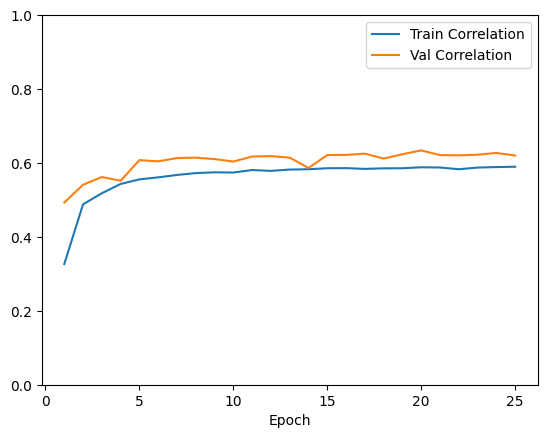

In [10]:
## RNN
"""
CNN + BiLSTM model for RNAcompete binding prediction.

Motifs are detected by a convolutional layer, and a bidirectional LSTM
models upstream/downstream context before fully connected layers map
features to binding affinity.
"""

import argparse
import json
import os
import time
from typing import Dict, List, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from argparse import Namespace

# from utils import (
# 	RNACompeteLoader,
# 	configure_seed,
# 	masked_mse_loss,
# 	masked_spearman_correlation,
# 	plot,
# 	dataset_summary,
# )
# from config import RNAConfig


# ============================================================================
# Model: CNN -> BiLSTM -> FC
# ============================================================================


class RNABindingCNNBiLSTM(nn.Module):
	"""Detect local motifs with CNN then model context with BiLSTM."""

	def __init__(
		self,
		num_filters: int = 64,
		kernel_size: int = 8,
		lstm_hidden: int = 64,
		lstm_layers: int = 1,
		dropout_rate: float = 0.3,
		input_channels: int = 4,
		seq_length: int = 41,
	):
		super().__init__()

		self.seq_length = seq_length
		self.num_directions = 2  # bidirectional
		self.lstm_layers = lstm_layers
		self.lstm_hidden = lstm_hidden

		# Motif detector
		self.conv1 = nn.Conv1d(
			in_channels=input_channels,
			out_channels=num_filters,
			kernel_size=kernel_size,
			stride=1,
			padding=kernel_size // 2,
		)

		# Batch Normalization after convolution for better regularization
		self.bn1 = nn.BatchNorm1d(num_filters)

		self.dropout_conv = nn.Dropout(dropout_rate * 0.5)

		# Context encoder
		self.lstm = nn.LSTM(
			input_size=num_filters,
			hidden_size=lstm_hidden,
			num_layers=lstm_layers,
			batch_first=True,
			bidirectional=True,
		)

		# FC head
		fc_in = lstm_hidden * self.num_directions
		self.fc1 = nn.Linear(fc_in, 128)
		self.bn_fc1 = nn.BatchNorm1d(128)
		self.fc2 = nn.Linear(128, 64)
		self.bn_fc2 = nn.BatchNorm1d(64)
		self.fc3 = nn.Linear(64, 1)

		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		# x: (batch, seq_len, 4)
		x = x.transpose(1, 2)  # -> (batch, 4, seq_len)
		x = self.conv1(x)
		x = self.bn1(x)
		x = F.relu(x)  # -> (batch, filters, seq_len)
		x = self.dropout_conv(x)

		# Prepare for LSTM
		x = x.transpose(1, 2)  # -> (batch, seq_len, filters)
		lstm_out, (h_n, _) = self.lstm(x)

		# Take last-layer forward/backward states and concatenate
		h_n = h_n.view(self.lstm_layers, self.num_directions, x.size(0), self.lstm_hidden)
		forward_last = h_n[-1, 0]
		backward_last = h_n[-1, 1]
		contextual = torch.cat([forward_last, backward_last], dim=1)

		x = self.fc1(contextual)
		x = self.bn_fc1(x)
		x = F.relu(x)
		x = self.dropout(x)

		x = self.fc2(x)
		x = self.bn_fc2(x)
		x = F.relu(x)
		x = self.dropout(x)

		x = self.fc3(x)
		return x


# ============================================================================
# Training / evaluation helpers
# ============================================================================


def train_epoch(
	model: nn.Module,
	train_loader: DataLoader,
	optimizer: optim.Optimizer,
	device: torch.device,
) -> Tuple[float, float]:
	model.train()
	total_loss = 0.0
	total_corr = 0.0
	num_batches = 0

	for batch_idx, (sequences, targets, masks) in enumerate(train_loader):
		sequences = sequences.to(device)
		targets = targets.to(device)
		masks = masks.to(device)

		optimizer.zero_grad()

		predictions = model(sequences)
		loss = masked_mse_loss(predictions, targets, masks)
		loss.backward()
		optimizer.step()

		with torch.no_grad():
			corr = masked_spearman_correlation(predictions, targets, masks)

		total_loss += loss.item()
		total_corr += corr.item()
		num_batches += 1

		# if (batch_idx + 1) % 50 == 0:
		# 	print(
		# 		f"  Batch {batch_idx + 1}/{len(train_loader)}: "
		# 		f"Loss = {loss.item():.4f}, Corr = {corr.item():.4f}"
		# 	)

	avg_loss = total_loss / num_batches
	avg_corr = total_corr / num_batches
	return avg_loss, avg_corr


def evaluate(
	model: nn.Module,
	data_loader: DataLoader,
	device: torch.device,
) -> Tuple[float, float]:
	model.eval()
	total_loss = 0.0
	total_corr = 0.0
	num_batches = 0

	with torch.no_grad():
		for sequences, targets, masks in data_loader:
			sequences = sequences.to(device)
			targets = targets.to(device)
			masks = masks.to(device)

			predictions = model(sequences)
			loss = masked_mse_loss(predictions, targets, masks)
			corr = masked_spearman_correlation(predictions, targets, masks)

			total_loss += loss.item()
			total_corr += corr.item()
			num_batches += 1

	avg_loss = total_loss / num_batches
	avg_corr = total_corr / num_batches
	return avg_loss, avg_corr



def train_model(
	model: nn.Module,
	train_loader: DataLoader,
	val_loader: DataLoader,
	num_epochs: int,
	learning_rate: float,
	device: torch.device,
	save_path: Optional[str] = None,
	weight_decay: float = 1e-3,
	early_stopping_patience: int = 5
) -> Dict[str, List[float]]:
	start_time = time.time()
	
	print(f"\n{'='*70}")
	print(f"Starting Training on {device}")
	print(f"{'='*70}")
	print(f"Regularization: Weight Decay = {weight_decay}, Early Stopping Patience = {early_stopping_patience}")

	optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

	history: Dict[str, List[float]] = {
		"train_loss": [],
		"train_corr": [],
		"val_loss": [],
		"val_corr": [],
	}

	best_val_corr = -1.0
	patience_counter = 0

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch + 1}/{num_epochs}")
		print(f"{'-'*70}")

		train_loss, train_corr = train_epoch(model, train_loader, optimizer, device)
		val_loss, val_corr = evaluate(model, val_loader, device)

		history["train_loss"].append(train_loss)
		history["train_corr"].append(train_corr)
		history["val_loss"].append(val_loss)
		history["val_corr"].append(val_corr)

		print(
			f"\nEpoch {epoch + 1} Summary:\n"
			f"  Train Loss: {train_loss:.4f} | Train Corr: {train_corr:.4f}\n"
			f"  Val Loss:   {val_loss:.4f} | Val Corr:   {val_corr:.4f}"
		)

		if val_corr > best_val_corr:
			best_val_corr = val_corr
			patience_counter = 0
			if save_path:
				torch.save(
					{
						"epoch": epoch,
						"model_state_dict": model.state_dict(),
						"optimizer_state_dict": optimizer.state_dict(),
						"val_corr": val_corr,
					},
					save_path,
				)
				print(f"  >>> New best model saved! (Val Corr: {val_corr:.4f})")
		else:
			patience_counter += 1
			print(f"  No improvement. Patience: {patience_counter}/{early_stopping_patience}")
			if patience_counter >= early_stopping_patience:
				print(f"\n{'='*70}")
				print(f"Early stopping triggered after {epoch + 1} epochs")
				print(f"{'='*70}\n")
				break

	elapsed_time = time.time() - start_time
	
	print(f"\n{'='*70}")
	print(f"Training Complete! Best Val Correlation: {best_val_corr:.4f}")
	print(f"Total Training Time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
	print(f"{'='*70}\n")

	history['elapsed_time'] = elapsed_time
	return history


# ============================================================================
# Hyperparameter search (small, curated)
# ============================================================================


def hyperparameter_search(
	protein_name: str,
	config: RNAConfig,
	device: torch.device,
	batch_size: int = 64,
	num_epochs: int = 15,
) -> Tuple[Dict, List[Dict]]:
	print(f"\n{'='*70}")
	print(f"HYPERPARAMETER SEARCH FOR {protein_name}")
	print(f"{'='*70}\n")

	print("Loading data (this will take a minute or two)...")
	loader = RNACompeteLoader(config)
	train_dataset = loader.get_data(protein_name, split="train")
	val_dataset = loader.get_data(protein_name, split="val")

	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

	test_configs = [       
		{"num_filters": 96, "kernel_size": 8, "lstm_hidden": 96,  "lstm_layers": 1, "dropout_rate": 0.5, "learning_rate": 5e-4},
		# Slightly higher capacity
		{"num_filters": 96, "kernel_size": 8, "lstm_hidden": 128, "lstm_layers": 1, "dropout_rate": 0.5, "learning_rate": 5e-4},
		{"num_filters": 96, "kernel_size": 8, "lstm_hidden": 64, "lstm_layers": 2, "dropout_rate": 0.5, "learning_rate": 5e-4},
    	{"num_filters": 96, "kernel_size": 8, "lstm_hidden": 96, "lstm_layers": 2, "dropout_rate": 0.5, "learning_rate": 5e-4},
    ]

	best_config: Optional[Dict] = None
	best_val_corr = -1.0
	all_results: List[Dict] = []

	for idx, params in enumerate(test_configs):
		print(f"\n{'='*70}")
		print(f"Configuration {idx + 1}/{len(test_configs)}")
		print(f"{'='*70}")
		print(f"Parameters: {params}")

		model = RNABindingCNNBiLSTM(
			num_filters=params["num_filters"],
			kernel_size=params["kernel_size"],
			lstm_hidden=params["lstm_hidden"],
			lstm_layers=params["lstm_layers"],
			dropout_rate=params["dropout_rate"],
		).to(device)

		history = train_model(
			model=model,
			train_loader=train_loader,
			val_loader=val_loader,
			num_epochs=num_epochs,
			learning_rate=params["learning_rate"],
			device=device,
			save_path=None,
		)

		final_val_corr = history["val_corr"][-1]
		all_results.append({"params": params, "final_val_corr": final_val_corr})

		if final_val_corr > best_val_corr:
			best_val_corr = final_val_corr
			best_config = params.copy()
			print(f"\n>>> NEW BEST CONFIGURATION! Val Corr: {final_val_corr:.4f}")

	print(f"\n{'='*70}")
	print("HYPERPARAMETER SEARCH COMPLETE")
	print(f"{'='*70}\n")
	print("Best Configuration:")
	for k, v in best_config.items():
		print(f"  {k}: {v}")
	print(f"\nBest Validation Correlation: {best_val_corr:.4f}")

	return best_config, all_results


# ============================================================================
# Data exploration helper
# ============================================================================


def run_data_exploration(
	protein_name: str,
	config: RNAConfig,
	output_dir: str = "results",
	splits: Tuple[str, ...] = ("train", "val", "test"),
) -> Dict[str, Dict]:
	os.makedirs(output_dir, exist_ok=True)
	loader = RNACompeteLoader(config)

	summaries: Dict[str, Dict] = {}
	for split in splits:
		print(f"Loading {protein_name} {split} split for exploration...")
		dataset = loader.get_data(protein_name, split=split)
		summary = dataset_summary(dataset)
		summaries[split] = summary

		summary_path = os.path.join(output_dir, f"{protein_name}_{split}_summary.json")
		with open(summary_path, "w") as f:
			json.dump(summary, f, indent=2)
		print(f"  Saved summary to {summary_path}")

	return summaries


# ============================================================================
# Main
# ============================================================================


def main():
    # parser = argparse.ArgumentParser(description="RNAcompete CNN+BiLSTM trainer and data explorer")
    # parser.add_argument("--protein", default="RBFOX1", help="Protein name to process")
    # parser.add_argument("--batch-size", type=int, default=64, help="Batch size for training")
    # parser.add_argument("--epochs", type=int, default=30, help="Number of training epochs")
    # parser.add_argument("--hyperparam-search", action="store_true", help="Run hyperparameter search instead of default config")
    # parser.add_argument("--explore-only", action="store_true", help="Only run data summary/plots and skip training")
    # args = parser.parse_args()
    args = Namespace(
        protein="RBFOX1",
        batch_size=64,
        epochs=50,
        hyperparam_search=False,
        explore_only=False,
    )
    
    configure_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    config = RNAConfig()
    os.makedirs("results", exist_ok=True)
    os.makedirs("models", exist_ok=True)

    if args.explore_only:
        print(f"\n{'='*70}")
        print(f"DATA EXPLORATION FOR {args.protein}")
        print(f"{'='*70}\n")
        run_data_exploration(protein_name=args.protein, config=config, output_dir="results")
        print("Data exploration finished. Skipping training as requested.")
        return

    if args.hyperparam_search:
        best_config, all_results = hyperparameter_search(
            protein_name=args.protein,
            config=config,
            device=device,
            batch_size=args.batch_size,
            num_epochs=15,
        )

        results_file = f"results/{args.protein}_hyperparameter_search_bilstm.json"
        with open(results_file, "w") as f:
            serializable_results = [
                {"params": res["params"], "final_val_corr": res["final_val_corr"]}
                for res in all_results
            ]
            json.dump({"best_config": best_config, "all_results": serializable_results}, f, indent=2)
        print(f"Hyperparameter search results saved to {results_file}")

    else:
        best_config = {
            "num_filters": 96,
            "kernel_size": 8,
            "lstm_hidden": 128,
            "lstm_layers": 1,
            "dropout_rate": 0.5,
            "learning_rate": 5e-4,
        }
        print("\nUsing default configuration:")
        for key, value in best_config.items():
            print(f"  {key}: {value}")

    print(f"\n{'='*70}")
    print(f"TRAINING FINAL MODEL FOR {args.protein}")
    print(f"{'='*70}\n")

    print("Loading data (this will take a minute or two)...")
    loader = RNACompeteLoader(config)
    train_dataset = loader.get_data(args.protein, split="train")
    val_dataset = loader.get_data(args.protein, split="val")
    test_dataset = loader.get_data(args.protein, split="test")

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    print(f"Train set: {len(train_dataset)} samples")
    print(f"Val set:   {len(val_dataset)} samples")
    print(f"Test set:  {len(test_dataset)} samples")

    model = RNABindingCNNBiLSTM(
        num_filters=best_config["num_filters"],
        kernel_size=best_config["kernel_size"],
        lstm_hidden=best_config["lstm_hidden"],
        lstm_layers=best_config["lstm_layers"],
        dropout_rate=best_config["dropout_rate"],
    ).to(device)

    print("\nModel Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

    model_save_path = f"models/{args.protein}_best_model_bilstm.pt"
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=args.epochs,
        learning_rate=best_config["learning_rate"],
        device=device,
        save_path=model_save_path,
    )

    print(f"\n{'='*70}")
    print("FINAL EVALUATION ON TEST SET")
    print(f"{'='*70}\n")

    checkpoint = torch.load(model_save_path, weights_only=True)
    model.load_state_dict(checkpoint["model_state_dict"])

    test_loss, test_corr = evaluate(model, test_loader, device)

    print(f"Test Loss:        {test_loss:.4f}")
    print(f"Test Correlation: {test_corr:.4f}")

    final_results = {
        "protein": args.protein,
        "config": best_config,
        "test_loss": test_loss,
        "test_correlation": test_corr,
        "training_time_seconds": history['elapsed_time'],
		"training_time_minutes": history['elapsed_time'] / 60,
		'history': {k: ([float(v) for v in vals] if isinstance(vals, list) else float(vals)) for k, vals in history.items()}
	}

    results_file = f"results/{args.protein}_final_results_bilstm.json"
    with open(results_file, "w") as f:
        json.dump(final_results, f, indent=2)
    print(f"\nResults saved to {results_file}")

    actual_epochs = len(history['train_loss'])
    epochs = list(range(1, actual_epochs + 1))

    plot(
        epochs=epochs,
        plottables={"Train Loss": history["train_loss"], "Val Loss": history["val_loss"]},
        filename=f"results/{args.protein}_loss_curve_bilstm.png",
    )
    print(f"Loss curve saved to results/{args.protein}_loss_curve_bilstm.png")

    plot(
        epochs=epochs,
        plottables={"Train Correlation": history["train_corr"], "Val Correlation": history["val_corr"]},
        filename=f"results/{args.protein}_correlation_curve_bilstm.png",
        ylim=[0, 1],
    )
    print(f"Correlation curve saved to results/{args.protein}_correlation_curve_bilstm.png")

    print(f"\n{'='*70}")
    print("ALL DONE!")
    print(f"{'='*70}\n")


if __name__ == "__main__":
	main()


In [ ]:
##Analysis
"""
Analysis script to evaluate validation correlation vs test correlation.

This helps identify:
- Overfitting (val corr much higher than test)
- Underfitting (val corr plateaus far from test)
- Optimal stopping point (where val corr is closest to test)
"""

import json
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Dict, Tuple


def load_results(protein_name: str, results_dir: str = "/kaggle/working/results") -> Dict:
    """Load training results from JSON."""
    results_path = os.path.join(results_dir, f"{protein_name}_final_results.json")
    with open(results_path, 'r') as f:
        return json.load(f)


def analyze_val_vs_test(results: Dict) -> Dict:
    """
    Analyze how close validation correlation gets to test correlation.
    
    Returns:
        Dictionary with analysis metrics
    """
    history = results['history']
    val_corrs = np.array(history['val_corr'])
    test_corr = results['test_correlation']
    
    # Find best validation epoch
    best_epoch = np.argmax(val_corrs)
    best_val_corr = val_corrs[best_epoch]
    
    # Calculate differences
    final_val_corr = val_corrs[-1]
    best_gap = test_corr - best_val_corr
    final_gap = test_corr - final_val_corr
    
    # Find epoch where val corr is closest to test
    abs_diffs = np.abs(val_corrs - test_corr)
    closest_epoch = np.argmin(abs_diffs)
    closest_val_corr = val_corrs[closest_epoch]
    min_gap = abs_diffs[closest_epoch]
    
    # Check for overfitting indicators
    val_peak = np.max(val_corrs)
    val_final = val_corrs[-1]
    overfitting_drop = val_peak - val_final
    
    analysis = {
        'test_correlation': test_corr,
        'best_val_correlation': best_val_corr,
        'best_val_epoch': int(best_epoch + 1),
        'final_val_correlation': final_val_corr,
        'final_epoch': len(val_corrs),
        'closest_val_correlation': closest_val_corr,
        'closest_epoch': int(closest_epoch + 1),
        'best_gap': best_gap,
        'final_gap': final_gap,
        'min_gap': min_gap,
        'overfitting_drop': overfitting_drop,
        'relative_error_best': abs(best_gap / test_corr) * 100,
        'relative_error_final': abs(final_gap / test_corr) * 100,
        'relative_error_closest': (min_gap / test_corr) * 100
    }
    
    return analysis


def print_analysis(analysis: Dict, protein_name: str):
    """Print formatted analysis report."""
    print(f"\n{'='*70}")
    print(f"VALIDATION vs TEST CORRELATION ANALYSIS - {protein_name}")
    print(f"{'='*70}\n")
    
    print("Test Set Performance:")
    print(f"  Test Correlation: {analysis['test_correlation']:.4f}")
    print()
    
    print("Validation Set Performance:")
    print(f"  Best Val Correlation:  {analysis['best_val_correlation']:.4f} (Epoch {analysis['best_val_epoch']})")
    print(f"  Final Val Correlation: {analysis['final_val_correlation']:.4f} (Epoch {analysis['final_epoch']})")
    print(f"  Closest to Test:       {analysis['closest_val_correlation']:.4f} (Epoch {analysis['closest_epoch']})")
    print()
    
    print("Gap Analysis (Val - Test):")
    print(f"  Gap at Best Val:    {analysis['best_gap']:+.4f} ({analysis['relative_error_best']:.2f}% relative error)")
    print(f"  Gap at Final Epoch: {analysis['final_gap']:+.4f} ({analysis['relative_error_final']:.2f}% relative error)")
    print(f"  Minimum Gap:        {analysis['min_gap']:+.4f} ({analysis['relative_error_closest']:.2f}% relative error)")
    print()
    
    print("Overfitting Indicators:")
    print(f"  Val Peak-to-Final Drop: {analysis['overfitting_drop']:.4f}")
    if analysis['overfitting_drop'] > 0.01:
        print("   Warning: Significant drop suggests overfitting")
    elif analysis['overfitting_drop'] < 0:
        print("  Still improving at end of training")
    else:
        print(" Minimal overfitting")
    print()
    
    print("Interpretation:")
    if abs(analysis['best_gap']) < 0.01:
        print("Excellent: Val correlation very close to test performance")
    elif abs(analysis['best_gap']) < 0.03:
        print("Good: Val correlation reasonably predicts test performance")
    elif analysis['best_gap'] < 0:
        print("Val correlation exceeds test (possible overfitting to val set)")
    else:
        print("Val correlation underestimates test (consider more training)")
    
    print(f"\n{'='*70}\n")


def plot_correlation_comparison(results: Dict, analysis: Dict, protein_name: str, 
                                 output_dir: str = "results"):
    """Create detailed plot comparing val and test correlations."""
    history = results['history']
    epochs = np.arange(1, len(history['val_corr']) + 1)
    val_corrs = np.array(history['val_corr'])
    train_corrs = np.array(history['train_corr'])
    test_corr = results['test_correlation']
    
    plt.figure(figsize=(12, 6))
    
    # Main plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_corrs, 'b-', label='Train', alpha=0.7, linewidth=2)
    plt.plot(epochs, val_corrs, 'g-', label='Validation', alpha=0.7, linewidth=2)
    plt.axhline(y=test_corr, color='r', linestyle='--', label='Test (final)', linewidth=2)
    
    # Mark best val epoch
    best_epoch = analysis['best_val_epoch']
    best_val = analysis['best_val_correlation']
    plt.scatter([best_epoch], [best_val], color='green', s=100, zorder=5, 
                marker='o', edgecolors='black', linewidths=2)
    
    # Mark closest to test
    closest_epoch = analysis['closest_epoch']
    closest_val = analysis['closest_val_correlation']
    plt.scatter([closest_epoch], [closest_val], color='orange', s=100, zorder=5,
                marker='*', edgecolors='black', linewidths=2)
    
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel('Spearman Correlation', fontsize=11)
    plt.title(f'{protein_name}: Correlation Progression', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim([0.35, max(train_corrs.max(), test_corr) + 0.05])
    
    # Gap plot
    plt.subplot(1, 2, 2)
    gaps = val_corrs - test_corr
    plt.plot(epochs, gaps, 'purple', linewidth=2, label='Val - Test Gap')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Perfect Match')
    plt.fill_between(epochs, gaps, 0, where=(gaps >= 0), alpha=0.3, color='green', label='Val > Test')
    plt.fill_between(epochs, gaps, 0, where=(gaps < 0), alpha=0.3, color='red', label='Val < Test')
    
    # Mark minimum gap
    plt.scatter([closest_epoch], [gaps[closest_epoch-1]], color='orange', s=100, 
                zorder=5, marker='*', edgecolors='black', linewidths=2)
    
    plt.xlabel('Epoch', fontsize=11)
    plt.ylabel('Correlation Gap (Val - Test)', fontsize=11)
    plt.title('Validation-Test Gap Analysis', fontsize=12, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    output_path = os.path.join(output_dir, f"{protein_name}_val_test_analysis.png")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"Analysis plot saved to {output_path}")
    plt.close()


def create_summary_table(analysis: Dict, output_dir: str = "results", 
                         protein_name: str = "RBFOX1"):
    """Create a summary table in JSON format."""
    summary = {
        'protein': protein_name,
        'test_correlation': round(analysis['test_correlation'], 4),
        'validation_metrics': {
            'best': {
                'correlation': round(analysis['best_val_correlation'], 4),
                'epoch': analysis['best_val_epoch'],
                'gap_from_test': round(analysis['best_gap'], 4),
                'relative_error_pct': round(analysis['relative_error_best'], 2)
            },
            'final': {
                'correlation': round(analysis['final_val_correlation'], 4),
                'epoch': analysis['final_epoch'],
                'gap_from_test': round(analysis['final_gap'], 4),
                'relative_error_pct': round(analysis['relative_error_final'], 2)
            },
            'closest_to_test': {
                'correlation': round(analysis['closest_val_correlation'], 4),
                'epoch': analysis['closest_epoch'],
                'gap_from_test': round(analysis['min_gap'], 4),
                'relative_error_pct': round(analysis['relative_error_closest'], 2)
            }
        },
        'overfitting_indicator': round(analysis['overfitting_drop'], 4)
    }
    
    output_path = os.path.join(output_dir, f"{protein_name}_val_test_summary.json")
    with open(output_path, 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"Summary table saved to {output_path}")


def main():
    """Run complete validation vs test analysis."""
    import argparse
    
    parser = argparse.ArgumentParser(description="Analyze validation vs test correlation")
    parser.add_argument("--protein", default="RBFOX1", help="Protein name to analyze")
    parser.add_argument("--results-dir", default="results", help="Results directory")
    
    args, _ = parser.parse_known_args()
    
    # Load results
    print(f"Loading results for {args.protein}...")
    results = load_results(args.protein, args.results_dir)
    
    # Analyze
    analysis = analyze_val_vs_test(results)
    
    # Print report
    print_analysis(analysis, args.protein)
    
    # Create visualizations
    plot_correlation_comparison(results, analysis, args.protein, args.results_dir)
    
    # Create summary table
    create_summary_table(analysis, args.results_dir, args.protein)
    
    print("Analysis complete!")


if __name__ == "__main__":
    main()


Using device: cuda

Using default configuration:
  num_filters: 96
  kernel_size: 8
  dropout_rate: 0.6
  learning_rate: 0.0005

TRAINING FINAL MODEL FOR RBFOX1

Loading data (this will take a minute or two)...
Found preprocessed data at /kaggle/input/rnacompete/RBFOX1_train_data.pt. Loading...
Found preprocessed data at /kaggle/input/rnacompete/RBFOX1_val_data.pt. Loading...
Found preprocessed data at /kaggle/input/rnacompete/RBFOX1_test_data.pt. Loading...
Train set: 96261 samples
Val set:   24065 samples
Test set:  121031 samples

Model Architecture:
RNABindingCNN(
  (conv1): Conv1d(4, 96, kernel_size=(8,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_conv): Dropout(p=0.3, inplace=False)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1920, out_features=128, bias=True)
  (bn_fc1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, tra

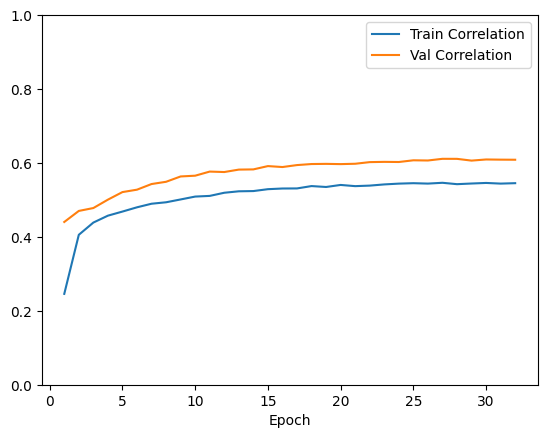

In [12]:
#MAIN
"""
RNA Binding Protein (RBP) Prediction using Convolutional Neural Networks

This script implements a CNN model for predicting RNA-protein binding affinities.
The CNN acts as a motif detector, identifying local sequence patterns associated 
with high binding affinity, similar to how RBPs scan RNA for binding sites.

Architecture:
    1. Convolutional Layer: Detects local motifs (binding patterns)
    2. Pooling Layer: Aggregates motif information (configurable strategy)
    3. Fully Connected Layers: Maps motif features to binding intensity
    4. Dropout: Regularization to prevent overfitting

Key Features:
    - Multiple pooling strategies (global max, local max, none)
    - Hyperparameter tuning for optimal performance
    - Masked loss to handle missing data points
    - Spearman correlation for evaluation
"""

import argparse
import json
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from typing import Dict, List, Tuple, Optional
from argparse import Namespace

# from utils import (
#     RNACompeteLoader,
#     configure_seed, 
#     masked_mse_loss, 
#     masked_spearman_correlation,
#     plot,
#     dataset_summary,
# )
# from config import RNAConfig


# ============================================================================
# Define the CNN Model Architecture
# ============================================================================

class RNABindingCNN(nn.Module):
    """
    Convolutional Neural Network for RNA Binding Prediction.
    
    The model uses 1D convolutions to detect sequence motifs, followed by
    pooling to aggregate information, and fully connected layers for prediction.
    
    Args:
        num_filters: Number of convolutional filters (motif detectors)
        kernel_size: Size of each filter (motif length to detect)
        dropout_rate: Dropout probability for regularization
        input_channels: Number of input channels (4 for one-hot RNA)
        seq_length: Length of input sequence (41 for RNAcompete)
    """
    
    def __init__(
        self, 
        num_filters: int = 96,
        kernel_size: int = 8,
        dropout_rate: float = 0.5,
        input_channels: int = 4,
        seq_length: int = 41
    ):
        super(RNABindingCNN, self).__init__()
        self.seq_length = seq_length
        
        # Convolutional Layer: Each filter acts as a motif detector
        # Input: (batch, 4, 41) -> Output: (batch, num_filters, L_out)
        self.conv1 = nn.Conv1d(
            in_channels=input_channels,
            out_channels=num_filters,
            kernel_size=kernel_size,
            stride=1,
            padding=(kernel_size - 1) // 2  # Keep sequence length similar
        )
        
        # Batch Normalization after convolution for better regularization
        self.bn1 = nn.BatchNorm1d(num_filters)
        
        # Dropout after convolution for stronger regularization
        self.dropout_conv = nn.Dropout(dropout_rate * 0.5)  # Lighter dropout for conv layer
        
        # Pooling Layer: Aggregates motif information
        self.pool_size = 2
        self.pool = nn.MaxPool1d(kernel_size=self.pool_size)

        # Calculate the output length after convolution and pooling
        conv_out_len = seq_length
        pool_out_len = conv_out_len // self.pool_size
        fc_input_size = num_filters * pool_out_len
        
        # Fully Connected Layers: Map motif features to binding intensity
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 1)  # Output: single binding intensity value
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        """
        Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, seq_length, 4)
        
        Returns:
            predictions: Tensor of shape (batch_size, 1)
        """
        # Input shape: (batch, 41, 4)
        # Conv1d expects: (batch, channels, length)
        x = x.transpose(1, 2)  # -> (batch, 4, 41)
        
        # Apply Conv -> BatchNorm -> ReLU -> Dropout
        x = self.conv1(x)  # -> (batch, num_filters, ~41)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_conv(x)
        
        # Local max: Preserve some positional information
        x = self.pool(x)  # -> (batch, num_filters, ~20)
        x = torch.flatten(x, 1)  # Flatten

        # Fully connected layers with BatchNorm, ReLU and dropout
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)  # -> (batch, 1)
        
        return x

# ============================================================================
# Training Function
# ============================================================================

def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    device: torch.device
) -> Tuple[float, float]:
    """
    Train the model for one epoch.
    
    Args:
        model: The CNN model
        train_loader: DataLoader for training data
        optimizer: Optimizer for updating weights
        device: Device to run on (CPU or CUDA)
    
    Returns:
        avg_loss: Average training loss
        avg_corr: Average Spearman correlation
    """
    model.train()
    total_loss = 0.0
    total_corr = 0.0
    num_batches = 0
    
    for batch_idx, (sequences, targets, masks) in enumerate(train_loader):
        # Move data to device
        sequences = sequences.to(device)
        targets = targets.to(device)
        masks = masks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(sequences)
        
        # Compute masked loss (ignores NaN values)
        loss = masked_mse_loss(predictions, targets, masks)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Compute metrics
        with torch.no_grad():
            corr = masked_spearman_correlation(predictions, targets, masks)
        
        total_loss += loss.item()
        total_corr += corr.item()
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_corr = total_corr / num_batches
    
    return avg_loss, avg_corr


# ============================================================================
# Evaluation Function
# ============================================================================

def evaluate(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device
) -> Tuple[float, float]:
    """
    Evaluate the model on validation or test set.
    
    Args:
        model: The CNN model
        data_loader: DataLoader for evaluation data
        device: Device to run on
    
    Returns:
        avg_loss: Average loss
        avg_corr: Average Spearman correlation
    """
    model.eval()
    total_loss = 0.0
    total_corr = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for sequences, targets, masks in data_loader:
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)
            masks = masks.to(device)
            
            # Forward pass
            predictions = model(sequences)
            
            # Compute metrics
            loss = masked_mse_loss(predictions, targets, masks)
            corr = masked_spearman_correlation(predictions, targets, masks)
            
            total_loss += loss.item()
            total_corr += corr.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_corr = total_corr / num_batches
    
    return avg_loss, avg_corr


# ============================================================================
# Full Training Loop
# ============================================================================

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: torch.device,
    save_path: Optional[str] = None,
    weight_decay: float = 1e-3,
    early_stopping_patience: int = 5
) -> Dict[str, List[float]]:
    """
    Train the model for multiple epochs with validation.
    
    Args:
        model: The CNN model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        device: Device to run on
        save_path: Path to save the best model (optional)
    
    Returns:
        history: Dictionary containing training metrics
    """
    start_time = time.time()
    
    print(f"\n{'='*70}")
    print(f"Starting Training on {device}")
    print(f"{'='*70}")
    print(f"Regularization: Weight Decay = {weight_decay}, Early Stopping Patience = {early_stopping_patience}")
    
    # Initialize optimizer with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Track metrics
    history = {
        'train_loss': [],
        'train_corr': [],
        'val_loss': [],
        'val_corr': []
    }
    
    best_val_corr = -1.0
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"{'-'*70}")
        

        train_loss, train_corr = train_epoch(model, train_loader, optimizer, device)
        

        val_loss, val_corr = evaluate(model, val_loader, device)
        

        history['train_loss'].append(train_loss)
        history['train_corr'].append(train_corr)
        history['val_loss'].append(val_loss)
        history['val_corr'].append(val_corr)
        

        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Corr: {train_corr:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Corr:   {val_corr:.4f}")
        
        # Save best model and check early stopping
        if val_corr > best_val_corr:
            best_val_corr = val_corr
            patience_counter = 0  # Reset patience counter
            if save_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_corr': val_corr,
                }, save_path)
                print(f"  >>> New best model saved! (Val Corr: {val_corr:.4f})")
        else:
            patience_counter += 1
            print(f"  >>> No improvement for {patience_counter} epoch(s)")
            
            if patience_counter >= early_stopping_patience:
                print(f"\n  Early stopping triggered after {epoch + 1} epochs!")
                print(f"  Best validation correlation: {best_val_corr:.4f}")
                break
    
    elapsed_time = time.time() - start_time
    
    print(f"\n{'='*70}")
    print(f"Training Complete! Best Val Correlation: {best_val_corr:.4f}")
    print(f"Total Training Time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    print(f"{'='*70}\n")
    
    history['elapsed_time'] = elapsed_time
    
    return history



# ============================================================================
# Hyperparameter Tuning
# ============================================================================

def hyperparameter_search(
    protein_name: str,
    config: RNAConfig,
    device: torch.device,
    batch_size: int = 64,
    num_epochs: int = 20
) -> Tuple[Dict, Dict]:
    """
    Perform grid search over hyperparameters.
    
    This function tests different combinations of:
    - Filter sizes (32, 64, 128)
    - Kernel sizes (6, 8, 10, 12)
    - Dropout rates (0.2, 0.3, 0.5, 0.6)
    - Learning rates (1e-3, 2e-4, 5e-4)
    
    Args:
        protein_name: Name of the protein to train on
        config: RNAConfig object
        device: Device to run on
        batch_size: Batch size for training
        num_epochs: Number of epochs per configuration
    
    Returns:
        best_config: Dictionary with best hyperparameters
        all_results: Dictionary with all results
    """
    print(f"\n{'='*70}")
    print(f"HYPERPARAMETER SEARCH FOR {protein_name}")
    print(f"{'='*70}\n")
    
    # Define hyperparameter grid
    param_grid = {
        'num_filters': [32, 64, 96],
        'kernel_size': [6, 8, 10, 12],
        'dropout_rate': [0.2, 0.3, 0.5, 0.6],
        'learning_rate': [1e-3, 2e-4, 5e-4]
    }
    
    # Load data once - create loader instance that will be reused
    print("Loading data (this will take a minute or two)...")
    loader = RNACompeteLoader(config)  # Create loader once
    train_dataset = loader.get_data(protein_name, split='train')
    val_dataset = loader.get_data(protein_name, split='val')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Generate all combinations (this could be large!)
    # For practical purposes, we'll do a smaller random search
    print(f"\nNote: Full grid search would test {np.prod([len(v) for v in param_grid.values()])} combinations.")
    print("Performing smart sampling of hyperparameter space...\n")
    
    # Sample a subset of combinations
    all_results = []
    best_val_corr = -1.0
    best_config = None
    
    # 6 optimized variations around the best performer (Rank 1: 0.6016 correlation)
    # Best: 64 filters, kernel 8, dropout 0.5, learning_rate 0.0005
    test_configs = [
        # Rank 1: Current best (keep for reproducibility)
        {'num_filters': 96, 'kernel_size': 8, 'dropout_rate': 0.5, 'learning_rate': 5e-4},
    
        # Rank 2: Baseline reference
        {'num_filters': 64, 'kernel_size': 8, 'dropout_rate': 0.5, 'learning_rate': 5e-4},
    
        # Variation 1: Higher capacity (test if still underfitting)
        {'num_filters': 128, 'kernel_size': 8, 'dropout_rate': 0.5, 'learning_rate': 5e-4},
    
        # Variation 2: Slightly wider motif around best kernel
        {'num_filters': 96, 'kernel_size': 10, 'dropout_rate': 0.5, 'learning_rate': 5e-4},
    
        # Variation 3: Slightly smaller kernel around best kernel
        {'num_filters': 96, 'kernel_size': 6, 'dropout_rate': 0.5, 'learning_rate': 5e-4},
    
        # Variation 4: Capacity increase + mild regularization
        {'num_filters': 128, 'kernel_size': 8, 'dropout_rate': 0.6, 'learning_rate': 5e-4},
    ]

    
    total_configs = len(test_configs)
    
    for idx, params in enumerate(test_configs):
        print(f"\n{'='*70}")
        print(f"Configuration {idx + 1}/{total_configs}")
        print(f"{'='*70}")
        print(f"Parameters: {params}")
        
        # Create model
        model = RNABindingCNN(
            num_filters=params['num_filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate']
        ).to(device)
        
        # Train model
        history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=num_epochs,
            learning_rate=params['learning_rate'],
            device=device,
            save_path=None  # Don't save intermediate models
        )
        
        # Get final validation correlation
        final_val_corr = history['val_corr'][-1]
        
        # Store results
        result = {
            'params': params,
            'final_val_corr': final_val_corr,
            'history': history
        }
        all_results.append(result)
        
        # Update best
        if final_val_corr > best_val_corr:
            best_val_corr = final_val_corr
            best_config = params.copy()
            print(f"\n>>> NEW BEST CONFIGURATION! Val Corr: {final_val_corr:.4f}")
    
    print(f"\n{'='*70}")
    print(f"HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*70}")
    print(f"\nBest Configuration:")
    for key, value in best_config.items():
        print(f"  {key}: {value}")
    print(f"\nBest Validation Correlation: {best_val_corr:.4f}")
    print(f"{'='*70}\n")
    
    return best_config, all_results


# ============================================================================
# Data Exploration Only (summary + plots)
# ============================================================================

def run_data_exploration(
    protein_name: str,
    config: RNAConfig,
    output_dir: str = "results",
    splits: Tuple[str, ...] = ("train", "val", "test")
) -> Dict[str, Dict]:
    """Generate dataset summaries and plots without training."""
    os.makedirs(output_dir, exist_ok=True)
    loader = RNACompeteLoader(config)

    summaries: Dict[str, Dict] = {}
    for split in splits:
        print(f"Loading {protein_name} {split} split for exploration...")
        dataset = loader.get_data(protein_name, split=split)
        summary = dataset_summary(dataset)
        summaries[split] = summary

        summary_path = os.path.join(output_dir, f"{protein_name}_{split}_summary.json")
        with open(summary_path, "w") as f:
            json.dump(summary, f, indent=2)
        print(f"  Saved summary to {summary_path}")

    return summaries


# ============================================================================
# Main Execution
# ============================================================================

def main():
    """
    Main execution function.
    
    This function:
    1. Sets up the environment (seed, device)
    2. Loads the data
    3. Performs hyperparameter search (optional)
    4. Trains the final model with best hyperparameters
    5. Evaluates on test set
    6. Saves results and plots
    """
    # parser = argparse.ArgumentParser(description="RNAcompete CNN trainer and data explorer")
    # parser.add_argument("--protein", default="RBFOX1", help="Protein name to process")
    # parser.add_argument("--batch-size", type=int, default=64, help="Batch size for training")
    # parser.add_argument("--epochs", type=int, default=30, help="Number of training epochs")
    # parser.add_argument("--hyperparam-search", action="store_true", help="Run hyperparameter search instead of default config")
    # parser.add_argument("--explore-only", action="store_true", help="Only run data summary/plots and skip training")
    # args = parser.parse_args()
    args = Namespace(
        protein="RBFOX1",
        batch_size=64,
        epochs=50,
        hyperparam_search=False,
        explore_only=False,
    )
    # ========================================================================
    # Configuration
    # ========================================================================

    configure_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    config = RNAConfig()
    os.makedirs('results', exist_ok=True)
    os.makedirs('models', exist_ok=True)

    # Early exit: exploration-only mode
    if args.explore_only:
        print(f"\n{'='*70}")
        print(f"DATA EXPLORATION FOR {args.protein}")
        print(f"{'='*70}\n")
        run_data_exploration(protein_name=args.protein, config=config, output_dir="results")
        print("Data exploration finished. Skipping training as requested.")
        return

    # ========================================================================
    # Hyperparameter Search
    # ========================================================================

    if args.hyperparam_search:
        best_config, all_results = hyperparameter_search(
            protein_name=args.protein,
            config=config,
            device=device,
            batch_size=args.batch_size,
            num_epochs=20  # Fewer epochs for search
        )

        results_file = f'results/{args.protein}_hyperparameter_search.json'
        with open(results_file, 'w') as f:
            serializable_results = []
            for result in all_results:
                serializable_results.append({
                    'params': result['params'],
                    'final_val_corr': result['final_val_corr']
                })
            json.dump({
                'best_config': best_config,
                'all_results': serializable_results
            }, f, indent=2)
        print(f"Hyperparameter search results saved to {results_file}")

    else:
        best_config = {
            'num_filters': 96,
            'kernel_size': 8,
            'dropout_rate': 0.6,
            'learning_rate': 5e-4
        }
        print(f"\nUsing default configuration:")
        for key, value in best_config.items():
            print(f"  {key}: {value}")

    # ========================================================================
    # Train Final Model with Best/Default Configuration
    # ========================================================================

    print(f"\n{'='*70}")
    print(f"TRAINING FINAL MODEL FOR {args.protein}")
    print(f"{'='*70}\n")

    print("Loading data (this will take a minute or two)...")
    loader = RNACompeteLoader(config)
    train_dataset = loader.get_data(args.protein, split='train')
    val_dataset = loader.get_data(args.protein, split='val')
    test_dataset = loader.get_data(args.protein, split='test')

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

    print(f"Train set: {len(train_dataset)} samples")
    print(f"Val set:   {len(val_dataset)} samples")
    print(f"Test set:  {len(test_dataset)} samples")

    model = RNABindingCNN(
        num_filters=best_config['num_filters'],
        kernel_size=best_config['kernel_size'],
        dropout_rate=best_config['dropout_rate']
    ).to(device)

    print(f"\nModel Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

    model_save_path = f"models/{args.protein}_best_model.pt"
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=args.epochs,
        learning_rate=best_config['learning_rate'],
        device=device,
        save_path=model_save_path
    )

    print(f"\n{'='*70}")
    print(f"FINAL EVALUATION ON TEST SET")
    print(f"{'='*70}\n")

    checkpoint = torch.load(model_save_path, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_corr = evaluate(model, test_loader, device)

    print(f"Test Loss:        {test_loss:.4f}")
    print(f"Test Correlation: {test_corr:.4f}")

    final_results = {
        'protein': args.protein,
        'config': best_config,
        'test_loss': test_loss,
        'test_correlation': test_corr,
        'training_time_seconds': history['elapsed_time'],
        'training_time_minutes': history['elapsed_time'] / 60,
        # Serialize lists to floats; scalars remain floats
        'history': {k: ([float(v) for v in vals] if isinstance(vals, list) else float(vals)) for k, vals in history.items()}
    }

    results_file = f'results/{args.protein}_final_results.json'
    with open(results_file, 'w') as f:
        json.dump(final_results, f, indent=2)
    print(f"\nResults saved to {results_file}")

    # Use actual number of epochs from history (handles early stopping)
    actual_epochs = len(history['train_loss'])
    epochs = list(range(1, actual_epochs + 1))

    plot(
        epochs=epochs,
        plottables={
            'Train Loss': history['train_loss'],
            'Val Loss': history['val_loss']
        },
        filename=f'results/{args.protein}_loss_curve.png'
    )
    print(f"Loss curve saved to results/{args.protein}_loss_curve.png")

    plot(
        epochs=epochs,
        plottables={
            'Train Correlation': history['train_corr'],
            'Val Correlation': history['val_corr']
        },
        filename=f'results/{args.protein}_correlation_curve.png',
        ylim=[0, 1]
    )
    print(f"Correlation curve saved to results/{args.protein}_correlation_curve.png")

    print(f"\n{'='*70}")
    print(f"ALL DONE!")
    print(f"{'='*70}\n")


if __name__ == "__main__":
    main()
